In [1]:
#import pathlib
import pandas as pd 
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import time

import nba_api
from nba_api.stats.static import teams, players
from nba_api.stats.endpoints import playercareerstats, leaguegamefinder, playerdashboardbyclutch, playergamelogs, commonplayerinfo, teamplayeronoffdetails, teamgamelogs
import pandas as pd

In [2]:
team_abbreviations = {
    "ATL": 1,
    "BKN": 2,
    "BOS": 3,
    "CHA": 4,
    "CHI": 5,
    "CLE": 6,
    "DAL": 7,	
    "DEN": 8,
    "DET": 9,
    "GSW": 10,	
    "HOU": 11,	
    "IND": 12,
    "LAC": 13,	
    "LAL": 14,	
    "MEM": 15, 	
    "MIA": 16,	
    "MIL": 17,	
    "MIN": 18,	
    "NOP": 19,
    "NOH": 19,	
    "NYK": 20,	
    "OKC": 21,	
    "ORL": 22,	
    "PHI": 23,	
    "PHX": 24,	
    "POR": 25,	
    "SAC": 26,	
    "SAS": 27,	
    "TOR": 28,	
    "UTA": 29,	
    "WAS": 30
}

In [3]:
class Team(object):
    def __init__(self, TeamID):
        
        self.TeamID =  TeamID 
        self.TeamName = teams.find_team_name_by_id(team_id=self.TeamID)['full_name']

        self.StartYear = 2009 
        self.LastYear = 2021
        

    def compile_active_team_data(self):
        
        points_scored_raw_data=[]
        matchup_raw_data = []
        location = []
        #team_season_point_average_raw_data = []
        #opponent_team_season_point_average_raw_data = []
        game_date_raw_data = []
        team_season_point_average_api_data = []
        team_season_point_average_raw_data = []
        team_season_points_raw_data = []
        opponent_season_point_average_raw_data = []
        opponent_season_points_average_api_data = []
        opponent_season_points_raw_data = []
        
        
        print(self.StartYear, self.LastYear)
        for year in range((self.StartYear), (self.LastYear)):
            print("-------------------------------------------------")
            season = str(year) + "-" + str(((year+1)-2000))
            teamLogs = teamgamelogs.TeamGameLogs(team_id_nullable=self.TeamID, season_nullable=season)
            print(season)
            

            points_scored_api_data=teamLogs.get_data_frames()[0]["PTS"]
            matchup_api_data = teamLogs.get_data_frames()[0]["MATCHUP"]
            team_season_points_api_data=teamLogs.get_data_frames()[0]["PTS"]
            game_date_api_data = teamLogs.get_data_frames()[0]["GAME_DATE"]
        

            print(teamLogs.get_data_frames()[0])


            season_team_points = []
            opponent_season_points = []
            for game in range(0, len(teamLogs.get_data_frames()[0])):
                    print(game, len(teamLogs.get_data_frames()[0]))
                    print(44444, game_date_api_data[game][:4])
                    game_date_raw_data.append(game_date_api_data[game][:4])
                    
                    points_scored_raw_data.append(points_scored_api_data[game])
                    team_season_points_raw_data.append(team_season_points_api_data[game])
                    season_team_points.append(team_season_points_api_data[game])
                    if game == 0:
                        team_season_point_average_raw_data.append(teamLogs.get_data_frames()[0]["PTS"][game])
                    else:
                        team_season_point_average_raw_data.append((sum(season_team_points)/len(season_team_points)))
                        
                        
                    team_abbreviation= teams.find_team_name_by_id(team_id=self.TeamID)['abbreviation']
                    matchup_api_data[game] = matchup_api_data[game].replace('NOH', 'NOP')
                    matchup_api_data[game] = matchup_api_data[game].replace('NJN', 'BKN')
                
                    if " vs. " in matchup_api_data[game]:
                        location.append(1)
                    elif "@" in matchup_api_data[game]:
                        location.append(2)

                    try:   
                        
                        matchup_api_data[game] = matchup_api_data[game].replace(team_abbreviation, "")
                        
                    except:
                        print("Unexpected Error with removing player team")
                    try:
                        matchup_api_data[game] = matchup_api_data[game].replace(" @ ", "")
                        matchup_api_data[game] = matchup_api_data[game].replace(" vs. ", "")
                    except:
                        print("Error")
                    
                    
                    
                    opponentAbbreviation = matchup_api_data[game]
                    matchup_api_data[game] = team_abbreviations[opponentAbbreviation]
                    matchup_raw_data.append(matchup_api_data[game])
                    opponentID = int(teams.find_team_by_abbreviation(opponentAbbreviation)["id"])
                    if (game%10==0):
                        print(game)
                        
                    opponentLogs = teamgamelogs.TeamGameLogs(team_id_nullable=opponentID, season_nullable=season)
                    opponent_season_points_api_data = opponentLogs.get_data_frames()[0]['PTS']
                    if game == 0:
                        opponent_season_point_average_raw_data.append(opponent_season_points_api_data[game])
                    elif game<(len(opponentLogs.get_data_frames()[0]['PTS'])):
                        opponent_season_point_average_raw_data.append(opponent_season_points_api_data.head(game).mean())
                    else:
                        opponent_season_point_average_raw_data.append(opponent_season_points_api_data.mean())
                    print(len(opponentLogs.get_data_frames()[0]['PTS']), opponent_season_point_average_raw_data[game])
                        
                    time.sleep(1)
                    

        print("the lengths")
        
        print(len(points_scored_raw_data))
        print(len(matchup_raw_data))
        print(len(team_season_point_average_raw_data))
        print(len(opponent_season_point_average_raw_data))
        print(len(location))
        team_data = {
        #"Player Name": player_name,
        "Points Scored": points_scored_raw_data,
        "Game Date": game_date_raw_data,
        #"MIN Played": min_played_raw_data,
        #"Win/Loss": win_loss_raw_data,
        #"Free Throws": free_throws_raw_data,
        #"Feild Goals 2pts": feild_goals_2pts_raw_data,
        #"Feild Goals 3pts": feild_goals_3pts_raw_data,
        "Matchup": matchup_raw_data,
        #"Location": location,
        "Team Point Average" : team_season_point_average_raw_data,
        "Opponent Team Point Average": opponent_season_point_average_raw_data 
        }

        team_dataFrame = pd.DataFrame(data=team_data)
        print(team_dataFrame)

        return(team_dataFrame)


    def get_active_team_data(self):
        return(self.compile_active_team_data())



In [4]:
#Data Preparation

test = Team(1610612751).get_active_team_data()




    
opponent = test.pop('Matchup')

test["ATL"] = (opponent == 1)*1.0
test["BKN"] = (opponent == 2)*1.0
test["BOS"] = (opponent == 3)*1.0
test["CHA"] = (opponent == 4)*1.0
test["CHI"] = (opponent == 5)*1.0
test["CLE"] = (opponent == 6)*1.0
test["DAL"] = (opponent == 7)*1.0
test["DEN"] = (opponent == 8)*1.0
test["DET"] = (opponent == 9)*1.0
test["GSW"] = (opponent == 10)*1.0
test["HOU"] = (opponent == 11)*1.0
test["IND"] = (opponent == 12)*1.0
test["LAC"] = (opponent == 13)*1.0
test["LAL"] = (opponent == 14)*1.0
test["MEM"] = (opponent == 15)*1.0
test["MIA"] = (opponent == 16)*1.0
test["MIL"] = (opponent == 17)*1.0
test["MIN"] = (opponent == 18)*1.0
test["NOP"] = (opponent == 19)*1.0
test["NYK"] = (opponent == 20)*1.0
test["OKC"] = (opponent == 21)*1.0
test["ORL"] = (opponent == 22)*1.0
test["PHI"] = (opponent == 23)*1.0
test["PHX"] = (opponent == 24)*1.0
test["POR"] = (opponent == 25)*1.0
test["SAC"] = (opponent == 26)*1.0
test["SAS"] = (opponent == 27)*1.0
test["TOR"] = (opponent == 28)*1.0
test["UTA"] = (opponent == 29)*1.0
test["WAS"] = (opponent == 30)*1.0		



test    



test = test.drop(columns=["BKN"])


print(test)




2009 2021
-------------------------------------------------
2009-10
   SEASON_YEAR     TEAM_ID TEAM_ABBREVIATION        TEAM_NAME     GAME_ID  \
0      2009-10  1610612751               NJN  New Jersey Nets  0020901222   
1      2009-10  1610612751               NJN  New Jersey Nets  0020901205   
2      2009-10  1610612751               NJN  New Jersey Nets  0020901188   
3      2009-10  1610612751               NJN  New Jersey Nets  0020901181   
4      2009-10  1610612751               NJN  New Jersey Nets  0020901162   
..         ...         ...               ...              ...         ...   
77     2009-10  1610612751               NJN  New Jersey Nets  0020900063   
78     2009-10  1610612751               NJN  New Jersey Nets  0020900046   
79     2009-10  1610612751               NJN  New Jersey Nets  0020900032   
80     2009-10  1610612751               NJN  New Jersey Nets  0020900027   
81     2009-10  1610612751               NJN  New Jersey Nets  0020900011   

       

82 94
1 82
44444 2011
82 89.0
2 82
44444 2011
82 97.5
3 82
44444 2011
82 101.0
4 82
44444 2011
82 96.75
5 82
44444 2011
82 99.2
6 82
44444 2011
82 104.33333333333333
7 82
44444 2011
82 107.0
8 82
44444 2011
82 104.125
9 82
44444 2011
82 99.77777777777777
10 82
44444 2011
10
82 97.8
11 82
44444 2011
82 95.72727272727273
12 82
44444 2011
82 99.66666666666667
13 82
44444 2011
82 105.38461538461539
14 82
44444 2011
82 99.64285714285714
15 82
44444 2011
82 98.4
16 82
44444 2011
82 104.4375
17 82
44444 2011
82 106.82352941176471
18 82
44444 2011
82 103.94444444444444
19 82
44444 2011
82 104.36842105263158
20 82
44444 2011
20
82 104.05
21 82
44444 2011
82 106.47619047619048
22 82
44444 2011
82 101.95454545454545
23 82
44444 2011
82 93.0
24 82
44444 2011
82 100.70833333333333
25 82
44444 2011
82 99.88
26 82
44444 2011
82 103.26923076923077
27 82
44444 2011
82 102.85185185185185
28 82
44444 2011
82 96.07142857142857
29 82
44444 2011
82 95.17241379310344
30 82
44444 2011
30
82 97.0
31 82
44444 2

65 66
44444 2011
66 101.04615384615384
-------------------------------------------------
2012-13
   SEASON_YEAR     TEAM_ID TEAM_ABBREVIATION      TEAM_NAME     GAME_ID  \
0      2012-13  1610612751               BKN  Brooklyn Nets  0021201217   
1      2012-13  1610612751               BKN  Brooklyn Nets  0021201205   
2      2012-13  1610612751               BKN  Brooklyn Nets  0021201195   
3      2012-13  1610612751               BKN  Brooklyn Nets  0021201178   
4      2012-13  1610612751               BKN  Brooklyn Nets  0021201168   
..         ...         ...               ...            ...         ...   
77     2012-13  1610612751               BKN  Brooklyn Nets  0021200090   
78     2012-13  1610612751               BKN  Brooklyn Nets  0021200069   
79     2012-13  1610612751               BKN  Brooklyn Nets  0021200056   
80     2012-13  1610612751               BKN  Brooklyn Nets  0021200043   
81     2012-13  1610612751               BKN  Brooklyn Nets  0021200029   

  

82 94
1 82
44444 2014
82 89.0
2 82
44444 2014
82 97.5
3 82
44444 2014
82 101.0
4 82
44444 2014
82 96.75
5 82
44444 2014
82 99.2
6 82
44444 2014
82 104.33333333333333
7 82
44444 2014
82 107.0
8 82
44444 2014
82 104.125
9 82
44444 2014
82 99.77777777777777
10 82
44444 2014
10
82 97.8
11 82
44444 2014
82 95.72727272727273
12 82
44444 2014
82 99.66666666666667
13 82
44444 2014
82 105.38461538461539
14 82
44444 2014
82 99.64285714285714
15 82
44444 2014
82 98.4
16 82
44444 2014
82 104.4375
17 82
44444 2014
82 106.82352941176471
18 82
44444 2014
82 103.94444444444444
19 82
44444 2014
82 104.36842105263158
20 82
44444 2014
20
82 104.05
21 82
44444 2014
82 106.47619047619048
22 82
44444 2014
82 101.95454545454545
23 82
44444 2014
82 93.0
24 82
44444 2014
82 100.70833333333333
25 82
44444 2014
82 99.88
26 82
44444 2014
82 103.26923076923077
27 82
44444 2014
82 102.85185185185185
28 82
44444 2014
82 96.07142857142857
29 82
44444 2014
82 95.17241379310344
30 82
44444 2014
30
82 97.0
31 82
44444 2

65 82
44444 2014
82 101.04615384615384
66 82
44444 2014
82 98.89393939393939
67 82
44444 2014
82 98.71641791044776
68 82
44444 2014
82 106.25
69 82
44444 2014
82 102.2463768115942
70 82
44444 2014
70
82 97.31428571428572
71 82
44444 2014
82 101.08450704225352
72 82
44444 2014
82 96.68055555555556
73 82
44444 2014
82 102.93150684931507
74 82
44444 2014
82 97.55405405405405
75 82
44444 2014
82 99.12
76 82
44444 2014
82 97.57894736842105
77 82
44444 2014
82 105.87012987012987
78 82
44444 2014
82 96.07692307692308
79 82
44444 2014
82 95.92405063291139
80 82
44444 2014
80
82 102.6375
81 82
44444 2014
82 98.22222222222223
-------------------------------------------------
2015-16
   SEASON_YEAR     TEAM_ID TEAM_ABBREVIATION      TEAM_NAME     GAME_ID  \
0      2015-16  1610612751               BKN  Brooklyn Nets  0021501218   
1      2015-16  1610612751               BKN  Brooklyn Nets  0021501206   
2      2015-16  1610612751               BKN  Brooklyn Nets  0021501199   
3      2015-16  16

82 94
1 82
44444 2017
82 89.0
2 82
44444 2017
82 97.5
3 82
44444 2017
82 101.0
4 82
44444 2017
82 96.75
5 82
44444 2017
82 99.2
6 82
44444 2017
82 104.33333333333333
7 82
44444 2017
82 107.0
8 82
44444 2017
82 104.125
9 82
44444 2017
82 99.77777777777777
10 82
44444 2017
10
82 97.8
11 82
44444 2017
82 95.72727272727273
12 82
44444 2017
82 99.66666666666667
13 82
44444 2017
82 105.38461538461539
14 82
44444 2017
82 99.64285714285714
15 82
44444 2017
82 98.4
16 82
44444 2017
82 104.4375
17 82
44444 2017
82 106.82352941176471
18 82
44444 2017
82 103.94444444444444
19 82
44444 2017
82 104.36842105263158
20 82
44444 2017
20
82 104.05
21 82
44444 2017
82 106.47619047619048
22 82
44444 2017
82 101.95454545454545
23 82
44444 2017
82 93.0
24 82
44444 2017
82 100.70833333333333
25 82
44444 2017
82 99.88
26 82
44444 2017
82 103.26923076923077
27 82
44444 2017
82 102.85185185185185
28 82
44444 2017
82 96.07142857142857
29 82
44444 2017
82 95.17241379310344
30 82
44444 2017
30
82 97.0
31 82
44444 2

65 82
44444 2017
82 101.04615384615384
66 82
44444 2017
82 98.89393939393939
67 82
44444 2017
82 98.71641791044776
68 82
44444 2017
82 106.25
69 82
44444 2017
82 102.2463768115942
70 82
44444 2017
70
82 97.31428571428572
71 82
44444 2017
82 101.08450704225352
72 82
44444 2017
82 96.68055555555556
73 82
44444 2017
82 102.93150684931507
74 82
44444 2017
82 97.55405405405405
75 82
44444 2017
82 99.12
76 82
44444 2017
82 97.57894736842105
77 82
44444 2017
82 105.87012987012987
78 82
44444 2017
82 96.07692307692308
79 82
44444 2017
82 95.92405063291139
80 82
44444 2017
80
82 102.6375
81 82
44444 2017
82 98.22222222222223
-------------------------------------------------
2018-19
   SEASON_YEAR     TEAM_ID TEAM_ABBREVIATION      TEAM_NAME     GAME_ID  \
0      2018-19  1610612751               BKN  Brooklyn Nets  0021801221   
1      2018-19  1610612751               BKN  Brooklyn Nets  0021801199   
2      2018-19  1610612751               BKN  Brooklyn Nets  0021801193   
3      2018-19  16

74 94
1 72
44444 2020
73 89.0
2 72
44444 2020
72 97.5
3 72
44444 2020
72 101.0
4 72
44444 2020
72 96.75
5 72
44444 2020
73 99.2
6 72
44444 2020
72 104.33333333333333
7 72
44444 2020
73 107.0
8 72
44444 2020
71 104.125
9 72
44444 2020
65 99.77777777777777
10 72
44444 2020
10
71 97.8
11 72
44444 2020
73 95.72727272727273
12 72
44444 2020
72 99.66666666666667
13 72
44444 2020
73 105.38461538461539
14 72
44444 2020
67 99.64285714285714
15 72
44444 2020
72 98.4
16 72
44444 2020
73 104.4375
17 72
44444 2020
65 106.82352941176471
18 72
44444 2020
73 103.94444444444444
19 72
44444 2020
72 104.36842105263158
20 72
44444 2020
20
73 104.05
21 72
44444 2020
72 106.47619047619048
22 72
44444 2020
65 101.95454545454545
23 72
44444 2020
73 93.0
24 72
44444 2020
72 100.70833333333333
25 72
44444 2020
65 99.88
26 72
44444 2020
66 103.26923076923077
27 72
44444 2020
66 102.85185185185185
28 72
44444 2020
66 96.07142857142857
29 72
44444 2020
71 95.17241379310344
30 72
44444 2020
30
73 97.0
31 72
44444 2

34 94
1 37
44444 2021
32 89.0
2 37
44444 2021
34 97.5
3 37
44444 2021
36 101.0
4 37
44444 2021
36 96.75
5 37
44444 2021
38 99.2
6 37
44444 2021
37 104.33333333333333
7 37
44444 2021
35 107.0
8 37
44444 2021
36 104.125
9 37
44444 2021
37 99.77777777777777
10 37
44444 2021
10
35 97.8
11 37
44444 2021
36 95.72727272727273
12 37
44444 2021
36 99.66666666666667
13 37
44444 2021
36 105.38461538461539
14 37
44444 2021
38 99.64285714285714
15 37
44444 2021
34 98.4
16 37
44444 2021
36 104.4375
17 37
44444 2021
36 106.82352941176471
18 37
44444 2021
36 103.94444444444444
19 37
44444 2021
36 104.36842105263158
20 37
44444 2021
20
36 104.05
21 37
44444 2021
36 106.47619047619048
22 37
44444 2021
36 101.95454545454545
23 37
44444 2021
36 93.0
24 37
44444 2021
37 100.70833333333333
25 37
44444 2021
36 99.88
26 37
44444 2021
36 103.26923076923077
27 37
44444 2021
32 102.85185185185185
28 37
44444 2021
36 96.07142857142857
29 37
44444 2021
36 95.17241379310344
30 37
44444 2021
30
34 97.0
31 37
44444 2

In [26]:
test["Game Date"] = test["Game Date"].replace(2010, 1)
test["Game Date"] = test["Game Date"].replace(2011, 2)
test["Game Date"] = test["Game Date"].replace(2012, 3)
test["Game Date"] = test["Game Date"].replace(2013, 4)
test["Game Date"] = test["Game Date"].replace(2014, 5)
test["Game Date"] = test["Game Date"].replace(2015, 6)
test["Game Date"] = test["Game Date"].replace(2016, 7)
test["Game Date"] = test["Game Date"].replace(2017, 8)
test["Game Date"] = test["Game Date"].replace(2018, 9)
test["Game Date"] = test["Game Date"].replace(2019, 10)
test["Game Date"] = test["Game Date"].replace(2020, 11)
test["Game Date"] = test["Game Date"].replace(2021, 12)


In [27]:
year_fix = test.pop('Game Date')

test["2010"] = (year_fix == 1)*1.0
test["2011"] = (year_fix == 2)*1.0
test["2012"] = (year_fix == 3)*1.0
test["2013"] = (year_fix == 4)*1.0
test["2014"] = (year_fix == 5)*1.0
test["2015"] = (year_fix == 6)*1.0
test["2016"] = (year_fix == 7)*1.0
test["2017"] = (year_fix == 8)*1.0
test["2018"] = (year_fix == 9)*1.0
test["2019"] = (year_fix == 10)*1.0
test["2020"] = (year_fix == 11)*1.0
test["2021"] = (year_fix == 11)*1.0

In [28]:
test = test.drop(columns=["2010","2011","2012","2013","2014","2015","2016","2017","2018","2019","2020","2021"]) #,"ATL", "BKN","BOS","CHA","CHI","CLE","DEN","DET","GSW","HOU","IND","LAC","LAL","MEM","MIA","MIL","MIN","NOP","NYK","OKC","ORL","PHI","PHX","POR","SAC","SAS","TOR","UTA","WAS"])

In [7]:
test

,Points Scored,Game Date,Team Point Average,Opponent Team Point Average,ATL,BOS,CHA,CHI,CLE,DAL,...,OKC,ORL,PHI,PHX,POR,SAC,SAS,TOR,UTA,WAS
0,86,2010,86.000000,94.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,95,2010,90.500000,89.000000,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,102,2010,94.333333,97.500000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,127,2010,102.500000,101.000000,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,89,2010,99.800000,96.750000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
908,145,2020,121.757576,110.593750,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
909,111,2020,121.441176,111.593750,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
910,104,2020,120.942857,112.676471,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
911,123,2020,121.000000,111.400000,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


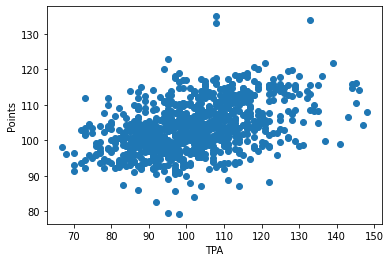

In [29]:
import matplotlib.pyplot as plt

plt.figure()
plt.xlabel("TPA")
plt.ylabel("Points")
plt.scatter(test["Points Scored"], test["Opponent Team Point Average"])

In [30]:
train_dataset = test.sample(frac=0.90, random_state=0)
test_dataset = test.drop(train_dataset.index)

In [31]:

test_dataset

,Points Scored,Team Point Average,Opponent Team Point Average,ATL,BOS,CHA,CHI,CLE,DAL,DEN,...,OKC,ORL,PHI,PHX,POR,SAC,SAS,TOR,UTA,WAS
9,83,99.100000,99.777778,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
28,84,96.586207,96.071429,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
42,95,94.441860,95.071429,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
47,89,94.291667,99.893617,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
53,99,93.944444,100.415094,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
850,109,111.659574,111.130435,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
852,108,111.387755,101.666667,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
862,101,111.186441,102.275862,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
880,127,122.000000,119.500000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [32]:
train_dataset


,Points Scored,Team Point Average,Opponent Team Point Average,ATL,BOS,CHA,CHI,CLE,DAL,DEN,...,OKC,ORL,PHI,PHX,POR,SAC,SAS,TOR,UTA,WAS
252,85,101.304348,94.590909,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
695,104,105.785714,104.527273,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
144,84,94.015873,92.774194,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
748,135,114.518519,108.153846,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
145,120,94.421875,105.285714,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
660,123,110.666667,113.450000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
143,75,94.177419,94.934426,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
180,102,94.882353,84.062500,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
131,81,95.080000,97.877551,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


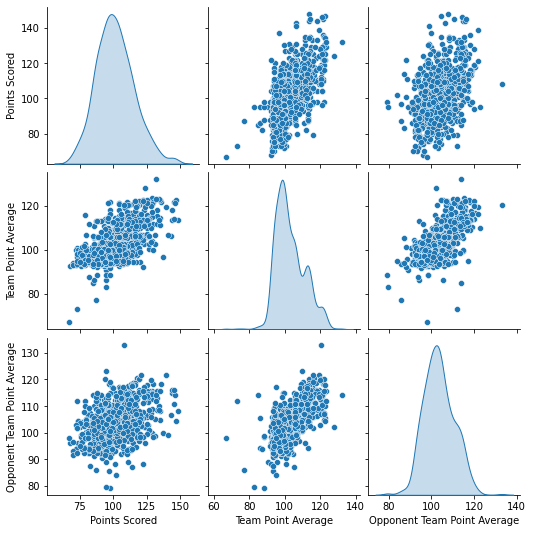

In [13]:
sns.pairplot(train_dataset[["Points Scored","Team Point Average", "Opponent Team Point Average"]], diag_kind="kde" )

In [33]:
train_stats = train_dataset.describe()
train_stats.pop("Points Scored")
train_stats = train_stats.transpose()
train_stats


,count,mean,std,min,25%,50%,75%,max
Team Point Average,822.0,102.924182,8.150729,67.00,97.136461,100.860577,107.202841,132.0
Opponent Team Point Average,822.0,103.528352,7.051751,79.25,98.604010,103.012500,108.204762,133.0
ATL,822.0,0.046229,0.210108,0.00,0.000000,0.000000,0.000000,1.0
BOS,822.0,0.047445,0.212719,0.00,0.000000,0.000000,0.000000,1.0
CHA,822.0,0.045012,0.207457,0.00,0.000000,0.000000,0.000000,1.0
CHI,822.0,0.041363,0.199249,0.00,0.000000,0.000000,0.000000,1.0
CLE,822.0,0.041363,0.199249,0.00,0.000000,0.000000,0.000000,1.0
DAL,822.0,0.023114,0.150358,0.00,0.000000,0.000000,0.000000,1.0
DEN,822.0,0.024331,0.154168,0.00,0.000000,0.000000,0.000000,1.0
DET,822.0,0.043796,0.204765,0.00,0.000000,0.000000,0.000000,1.0


In [34]:
train_labels = train_dataset.pop("Points Scored")
test_labels = test_dataset.pop("Points Scored")

In [35]:
train_labels

252     85
695    104
144     84
748    135
145    120
      ... 
660    123
143     75
180    102
131     81
864    117
Name: Points Scored, Length: 822, dtype: int64

In [36]:
test_labels

9       83
28      84
42      95
47      89
53      99
      ... 
850    109
852    108
862    101
880    127
896    113
Name: Points Scored, Length: 91, dtype: int64

In [37]:
train_dataset

,Team Point Average,Opponent Team Point Average,ATL,BOS,CHA,CHI,CLE,DAL,DEN,DET,...,OKC,ORL,PHI,PHX,POR,SAC,SAS,TOR,UTA,WAS
252,101.304348,94.590909,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
695,105.785714,104.527273,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
144,94.015873,92.774194,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
748,114.518519,108.153846,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
145,94.421875,105.285714,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
660,110.666667,113.450000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
143,94.177419,94.934426,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
180,94.882353,84.062500,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
131,95.080000,97.877551,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [38]:

def sigmoid(x):
    return(x - train_stats['mean'])/train_stats['std']
normed_train_data = sigmoid(train_dataset)
normed_test_data = sigmoid(test_dataset)


In [39]:
normed_train_data

,Team Point Average,Opponent Team Point Average,ATL,BOS,CHA,CHI,CLE,DAL,DEN,DET,...,OKC,ORL,PHI,PHX,POR,SAC,SAS,TOR,UTA,WAS
252,-0.198735,-1.267408,-0.220024,-0.223042,-0.216971,4.811265,-0.207593,-0.153729,-0.157821,-0.213883,...,-0.161819,-0.223042,-0.237669,-0.161819,-0.149535,-0.157821,-0.157821,-0.226028,-0.157821,-0.220024
695,0.351077,0.141656,-0.220024,-0.223042,-0.216971,-0.207593,-0.207593,-0.153729,-0.157821,-0.213883,...,-0.161819,-0.223042,-0.237669,-0.161819,-0.149535,-0.157821,-0.157821,-0.226028,-0.157821,-0.220024
144,-1.092946,-1.525034,-0.220024,-0.223042,4.603304,-0.207593,-0.207593,-0.153729,-0.157821,-0.213883,...,-0.161819,-0.223042,-0.237669,-0.161819,-0.149535,-0.157821,-0.157821,-0.226028,-0.157821,-0.220024
748,1.422491,0.655936,-0.220024,-0.223042,-0.216971,-0.207593,-0.207593,-0.153729,6.328603,-0.213883,...,-0.161819,-0.223042,-0.237669,-0.161819,-0.149535,-0.157821,-0.157821,-0.226028,-0.157821,-0.220024
145,-1.043135,0.249209,-0.220024,-0.223042,-0.216971,-0.207593,-0.207593,-0.153729,-0.157821,-0.213883,...,6.172233,-0.223042,-0.237669,-0.161819,-0.149535,-0.157821,-0.157821,-0.226028,-0.157821,-0.220024
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
660,0.949913,1.406977,-0.220024,-0.223042,-0.216971,-0.207593,4.811265,-0.153729,-0.157821,-0.213883,...,-0.161819,-0.223042,-0.237669,-0.161819,-0.149535,-0.157821,-0.157821,-0.226028,-0.157821,-0.220024
143,-1.073126,-1.218694,-0.220024,4.478002,-0.216971,-0.207593,-0.207593,-0.153729,-0.157821,-0.213883,...,-0.161819,-0.223042,-0.237669,-0.161819,-0.149535,-0.157821,-0.157821,-0.226028,-0.157821,-0.220024
180,-0.986639,-2.760428,-0.220024,-0.223042,4.603304,-0.207593,-0.207593,-0.153729,-0.157821,-0.213883,...,-0.161819,-0.223042,-0.237669,-0.161819,-0.149535,-0.157821,-0.157821,-0.226028,-0.157821,-0.220024
131,-0.962390,-0.801333,-0.220024,-0.223042,-0.216971,4.811265,-0.207593,-0.153729,-0.157821,-0.213883,...,-0.161819,-0.223042,-0.237669,-0.161819,-0.149535,-0.157821,-0.157821,-0.226028,-0.157821,-0.220024


In [40]:
normed_test_data

,Team Point Average,Opponent Team Point Average,ATL,BOS,CHA,CHI,CLE,DAL,DEN,DET,...,OKC,ORL,PHI,PHX,POR,SAC,SAS,TOR,UTA,WAS
9,-0.469183,-0.531864,-0.220024,-0.223042,-0.216971,4.811265,-0.207593,-0.153729,-0.157821,-0.213883,...,-0.161819,-0.223042,-0.237669,-0.161819,-0.149535,-0.157821,-0.157821,-0.226028,-0.157821,-0.220024
28,-0.777596,-1.057457,-0.220024,-0.223042,-0.216971,-0.207593,-0.207593,-0.153729,-0.157821,-0.213883,...,-0.161819,-0.223042,-0.237669,-0.161819,-0.149535,-0.157821,-0.157821,-0.226028,-0.157821,-0.220024
42,-1.040683,-1.199266,-0.220024,-0.223042,-0.216971,-0.207593,-0.207593,-0.153729,-0.157821,-0.213883,...,-0.161819,-0.223042,-0.237669,-0.161819,-0.149535,-0.157821,-0.157821,-0.226028,-0.157821,-0.220024
47,-1.059110,-0.515437,4.539436,-0.223042,-0.216971,-0.207593,-0.207593,-0.153729,-0.157821,-0.213883,...,-0.161819,-0.223042,-0.237669,-0.161819,-0.149535,-0.157821,-0.157821,-0.226028,-0.157821,-0.220024
53,-1.101710,-0.441487,-0.220024,-0.223042,-0.216971,-0.207593,-0.207593,-0.153729,-0.157821,-0.213883,...,-0.161819,-0.223042,-0.237669,-0.161819,-0.149535,-0.157821,-0.157821,-0.226028,-0.157821,-0.220024
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
850,1.071731,1.078042,-0.220024,-0.223042,-0.216971,-0.207593,-0.207593,-0.153729,-0.157821,-0.213883,...,-0.161819,-0.223042,4.202417,-0.161819,-0.149535,-0.157821,-0.157821,-0.226028,-0.157821,-0.220024
852,1.038382,-0.264003,-0.220024,-0.223042,4.603304,-0.207593,-0.207593,-0.153729,-0.157821,-0.213883,...,-0.161819,-0.223042,-0.237669,-0.161819,-0.149535,-0.157821,-0.157821,-0.226028,-0.157821,-0.220024
862,1.013683,-0.177614,-0.220024,-0.223042,4.603304,-0.207593,-0.207593,-0.153729,-0.157821,-0.213883,...,-0.161819,-0.223042,-0.237669,-0.161819,-0.149535,-0.157821,-0.157821,-0.226028,-0.157821,-0.220024
880,2.340382,2.264919,-0.220024,-0.223042,-0.216971,-0.207593,-0.207593,-0.153729,-0.157821,-0.213883,...,-0.161819,-0.223042,-0.237669,-0.161819,-0.149535,6.328603,-0.157821,-0.226028,-0.157821,-0.220024


In [41]:
def build_model():
    '''
    input_layer=tf.keras.layers.Input(([len(train_dataset.keys())]))
    densel_layer = tf.keras.layers.Dense(units=1, input_shape=([len(train_dataset.keys())],))
    output = densel_layer(input_layer)
    model = tf.keras.Model(inputs=input_layer,outputs=output)
    
    model.compile(loss="mse",optimizer=tf.keras.optimizers.Adam(0.1), metrics=['mae', 'mse'])
    
    '''
    print([len(train_dataset.keys())])
    model = keras.Sequential([
        
        layers.Dense(15, activation=tf.nn.relu, input_shape=[len(train_dataset.keys())]),
        layers.Dense(25, activation=tf.nn.relu),
        layers.Dense(1)
    ])

    optimizer = tf.keras.optimizers.RMSprop(0.001)

    model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
    
    
    return model

In [42]:
model = build_model()

[31]


In [43]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 15)                480       
_________________________________________________________________
dense_4 (Dense)              (None, 25)                400       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 26        
Total params: 906
Trainable params: 906
Non-trainable params: 0
_________________________________________________________________


In [44]:
example_batch = normed_train_data
print((example_batch.keys()))
example_result = model.predict(example_batch)
example_result

Index(['Team Point Average', 'Opponent Team Point Average', 'ATL', 'BOS',
       'CHA', 'CHI', 'CLE', 'DAL', 'DEN', 'DET', 'GSW', 'HOU', 'IND', 'LAC',
       'LAL', 'MEM', 'MIA', 'MIL', 'MIN', 'NOP', 'NYK', 'OKC', 'ORL', 'PHI',
       'PHX', 'POR', 'SAC', 'SAS', 'TOR', 'UTA', 'WAS'],
      dtype='object')


array([[-2.90932536e-01],
       [-5.83103746e-02],
       [ 3.46919417e-01],
       [ 1.34821057e+00],
       [ 2.97794253e-01],
       [-2.17037201e-02],
       [-9.46434379e-01],
       [-1.76919937e-01],
       [ 4.54465657e-01],
       [-2.63788372e-01],
       [-7.69576430e-02],
       [-1.98819458e-01],
       [ 6.54787719e-01],
       [ 4.30609912e-01],
       [-1.06699735e-01],
       [-1.83876172e-01],
       [-2.65227377e-01],
       [-6.48018956e-01],
       [ 6.15292251e-01],
       [ 4.54228342e-01],
       [-4.77023900e-01],
       [ 6.62025154e-01],
       [ 7.13033795e-01],
       [-1.04992759e+00],
       [-5.32944143e-01],
       [-9.81969237e-01],
       [-8.30598950e-01],
       [ 1.09317207e+00],
       [ 3.78456980e-01],
       [ 1.62551820e+00],
       [-8.69632661e-01],
       [ 2.90601313e-01],
       [-4.96670127e-01],
       [ 1.98233351e-01],
       [-3.54642123e-01],
       [-3.69601808e-02],
       [ 6.97151124e-02],
       [ 2.81546831e-01],
       [-5.0

In [54]:
class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0:
            print('')
        print('.', end='')
EPOCHS = 1000
history = model.fit(
    normed_train_data, train_labels,
    epochs=EPOCHS, callbacks=[PrintDot()])
'''history = model.fit(
    normed_train_data, train_labels,
    epochs=EPOCHS, validation_split= 0.2, verbose=0,
    callbacks=[PrintDot()])'''

Epoch 1/1000
26/26 [==============================] - 0s 1ms/step - loss: 118.1832 - mae: 8.4968 - mse: 118.1832

.Epoch 2/1000
26/26 [==============================] - 0s 2ms/step - loss: 117.9066 - mae: 8.5008 - mse: 117.9066
.Epoch 3/1000
26/26 [==============================] - 0s 2ms/step - loss: 118.0279 - mae: 8.5099 - mse: 118.0279
.Epoch 4/1000
26/26 [==============================] - 0s 1ms/step - loss: 117.3534 - mae: 8.4384 - mse: 117.3534
.Epoch 5/1000
26/26 [==============================] - 0s 2ms/step - loss: 117.6879 - mae: 8.4871 - mse: 117.6879
.Epoch 6/1000
26/26 [==============================] - 0s 2ms/step - loss: 117.7320 - mae: 8.4730 - mse: 117.7320
.Epoch 7/1000
26/26 [==============================] - 0s 2ms/step - loss: 117.7190 - mae: 8.5024 - mse: 117.7190
.Epoch 8/1000
26/26 [==============================] - 0s 4ms/step - loss: 117.3083 - mae: 8.4818 - mse: 117.3083
.Epoch 9/1000
26/26 [==============================] - 0s 3ms/step - loss: 117.5378 - ma

26/26 [==============================] - 0s 2ms/step - loss: 115.1171 - mae: 8.3634 - mse: 115.1171
.Epoch 73/1000
26/26 [==============================] - 0s 3ms/step - loss: 114.9587 - mae: 8.3622 - mse: 114.9587
.Epoch 74/1000
26/26 [==============================] - 0s 2ms/step - loss: 115.3183 - mae: 8.3920 - mse: 115.3183
.Epoch 75/1000
26/26 [==============================] - 0s 2ms/step - loss: 115.1543 - mae: 8.3747 - mse: 115.1543
.Epoch 76/1000
26/26 [==============================] - 0s 2ms/step - loss: 115.1337 - mae: 8.3773 - mse: 115.1337
.Epoch 77/1000
26/26 [==============================] - 0s 2ms/step - loss: 115.0152 - mae: 8.3726 - mse: 115.0152
.Epoch 78/1000
26/26 [==============================] - 0s 2ms/step - loss: 114.9584 - mae: 8.3860 - mse: 114.9584
.Epoch 79/1000
26/26 [==============================] - 0s 2ms/step - loss: 115.0581 - mae: 8.3767 - mse: 115.0581
.Epoch 80/1000
26/26 [==============================] - 0s 1ms/step - loss: 114.5684 - mae: 8.3

.Epoch 143/1000
26/26 [==============================] - 0s 2ms/step - loss: 114.3391 - mae: 8.3470 - mse: 114.3391
.Epoch 144/1000
26/26 [==============================] - 0s 1ms/step - loss: 114.4436 - mae: 8.3293 - mse: 114.4436
.Epoch 145/1000
26/26 [==============================] - 0s 1ms/step - loss: 113.9473 - mae: 8.3510 - mse: 113.9473
.Epoch 146/1000
26/26 [==============================] - 0s 2ms/step - loss: 114.1786 - mae: 8.3291 - mse: 114.1786
.Epoch 147/1000
26/26 [==============================] - 0s 2ms/step - loss: 113.6741 - mae: 8.2736 - mse: 113.6741
.Epoch 148/1000
26/26 [==============================] - 0s 2ms/step - loss: 114.2935 - mae: 8.3602 - mse: 114.2935
.Epoch 149/1000
26/26 [==============================] - 0s 2ms/step - loss: 113.6136 - mae: 8.3041 - mse: 113.6136
.Epoch 150/1000
26/26 [==============================] - 0s 2ms/step - loss: 114.0428 - mae: 8.3421 - mse: 114.0428
.Epoch 151/1000
26/26 [==============================] - 0s 2ms/step - l

26/26 [==============================] - 0s 3ms/step - loss: 113.7806 - mae: 8.3178 - mse: 113.7806
.Epoch 214/1000
26/26 [==============================] - 0s 4ms/step - loss: 113.3601 - mae: 8.3250 - mse: 113.3601
.Epoch 215/1000
26/26 [==============================] - 0s 2ms/step - loss: 113.1657 - mae: 8.3433 - mse: 113.1657
.Epoch 216/1000
26/26 [==============================] - 0s 2ms/step - loss: 113.6753 - mae: 8.3164 - mse: 113.6753
.Epoch 217/1000
26/26 [==============================] - 0s 2ms/step - loss: 113.3776 - mae: 8.3249 - mse: 113.3776
.Epoch 218/1000
26/26 [==============================] - 0s 2ms/step - loss: 112.8804 - mae: 8.2788 - mse: 112.8804
.Epoch 219/1000
26/26 [==============================] - 0s 2ms/step - loss: 113.6115 - mae: 8.3341 - mse: 113.6115
.Epoch 220/1000
26/26 [==============================] - 0s 2ms/step - loss: 113.5354 - mae: 8.3227 - mse: 113.5354
.Epoch 221/1000
26/26 [==============================] - 0s 2ms/step - loss: 113.2116 - 

26/26 [==============================] - 0s 2ms/step - loss: 113.2980 - mae: 8.3056 - mse: 113.2980
.Epoch 284/1000
26/26 [==============================] - 0s 2ms/step - loss: 113.0608 - mae: 8.2893 - mse: 113.0608
.Epoch 285/1000
26/26 [==============================] - 0s 2ms/step - loss: 113.0293 - mae: 8.3238 - mse: 113.0293
.Epoch 286/1000
26/26 [==============================] - 0s 2ms/step - loss: 112.6819 - mae: 8.2819 - mse: 112.6819
.Epoch 287/1000
26/26 [==============================] - 0s 3ms/step - loss: 112.3750 - mae: 8.2920 - mse: 112.3750
.Epoch 288/1000
26/26 [==============================] - 0s 2ms/step - loss: 113.4045 - mae: 8.3141 - mse: 113.4045
.Epoch 289/1000
26/26 [==============================] - 0s 2ms/step - loss: 113.3286 - mae: 8.3211 - mse: 113.3286
.Epoch 290/1000
26/26 [==============================] - 0s 2ms/step - loss: 113.1478 - mae: 8.3053 - mse: 113.1478
.Epoch 291/1000
26/26 [==============================] - 0s 2ms/step - loss: 112.8992 - 

26/26 [==============================] - 0s 2ms/step - loss: 112.6985 - mae: 8.3043 - mse: 112.6985
.Epoch 354/1000
26/26 [==============================] - 0s 2ms/step - loss: 113.0016 - mae: 8.3197 - mse: 113.0016
.Epoch 355/1000
26/26 [==============================] - 0s 2ms/step - loss: 112.7319 - mae: 8.3093 - mse: 112.7319
.Epoch 356/1000
26/26 [==============================] - 0s 2ms/step - loss: 113.0787 - mae: 8.2842 - mse: 113.0787
.Epoch 357/1000
26/26 [==============================] - 0s 2ms/step - loss: 112.8580 - mae: 8.3027 - mse: 112.8580
.Epoch 358/1000
26/26 [==============================] - 0s 3ms/step - loss: 112.7263 - mae: 8.3159 - mse: 112.7263
.Epoch 359/1000
26/26 [==============================] - 0s 3ms/step - loss: 112.7276 - mae: 8.2588 - mse: 112.7276
.Epoch 360/1000
26/26 [==============================] - 0s 2ms/step - loss: 113.1098 - mae: 8.3130 - mse: 113.1098
.Epoch 361/1000
26/26 [==============================] - 0s 2ms/step - loss: 112.4965 - 

26/26 [==============================] - 0s 2ms/step - loss: 112.3535 - mae: 8.2761 - mse: 112.3535
.Epoch 423/1000
26/26 [==============================] - 0s 2ms/step - loss: 111.5892 - mae: 8.2730 - mse: 111.5892
.Epoch 424/1000
26/26 [==============================] - 0s 2ms/step - loss: 112.4939 - mae: 8.3013 - mse: 112.4939
.Epoch 425/1000
26/26 [==============================] - 0s 2ms/step - loss: 112.0578 - mae: 8.2775 - mse: 112.0578
.Epoch 426/1000
26/26 [==============================] - 0s 2ms/step - loss: 112.1581 - mae: 8.2965 - mse: 112.1581
.Epoch 427/1000
26/26 [==============================] - 0s 2ms/step - loss: 112.4568 - mae: 8.2999 - mse: 112.4568
.Epoch 428/1000
26/26 [==============================] - 0s 2ms/step - loss: 112.0351 - mae: 8.2618 - mse: 112.0351
.Epoch 429/1000
26/26 [==============================] - 0s 2ms/step - loss: 112.0297 - mae: 8.2564 - mse: 112.0297
.Epoch 430/1000
26/26 [==============================] - 0s 2ms/step - loss: 112.3878 - 

26/26 [==============================] - 0s 2ms/step - loss: 111.6771 - mae: 8.2575 - mse: 111.6771
.Epoch 493/1000
26/26 [==============================] - 0s 2ms/step - loss: 111.8241 - mae: 8.2549 - mse: 111.8241
.Epoch 494/1000
26/26 [==============================] - 0s 2ms/step - loss: 111.7597 - mae: 8.2406 - mse: 111.7597
.Epoch 495/1000
26/26 [==============================] - 0s 3ms/step - loss: 112.3088 - mae: 8.2926 - mse: 112.3088
.Epoch 496/1000
26/26 [==============================] - 0s 2ms/step - loss: 111.8136 - mae: 8.2576 - mse: 111.8136
.Epoch 497/1000
26/26 [==============================] - 0s 2ms/step - loss: 111.5093 - mae: 8.2358 - mse: 111.5093
.Epoch 498/1000
26/26 [==============================] - 0s 2ms/step - loss: 111.4655 - mae: 8.2447 - mse: 111.4655
.Epoch 499/1000
26/26 [==============================] - 0s 2ms/step - loss: 111.7787 - mae: 8.2574 - mse: 111.7787
.Epoch 500/1000
26/26 [==============================] - 0s 2ms/step - loss: 112.1331 - 

26/26 [==============================] - 0s 3ms/step - loss: 110.7581 - mae: 8.2304 - mse: 110.7581
.Epoch 563/1000
26/26 [==============================] - 0s 3ms/step - loss: 111.0790 - mae: 8.2270 - mse: 111.0790
.Epoch 564/1000
26/26 [==============================] - 0s 2ms/step - loss: 111.1156 - mae: 8.2186 - mse: 111.1156
.Epoch 565/1000
26/26 [==============================] - 0s 2ms/step - loss: 110.8084 - mae: 8.2163 - mse: 110.8084
.Epoch 566/1000
26/26 [==============================] - 0s 2ms/step - loss: 110.5775 - mae: 8.2462 - mse: 110.5775
.Epoch 567/1000
26/26 [==============================] - 0s 2ms/step - loss: 111.0082 - mae: 8.2299 - mse: 111.0082
.Epoch 568/1000
26/26 [==============================] - 0s 2ms/step - loss: 110.9754 - mae: 8.2191 - mse: 110.9754
.Epoch 569/1000
26/26 [==============================] - 0s 3ms/step - loss: 110.9091 - mae: 8.2213 - mse: 110.9091
.Epoch 570/1000
26/26 [==============================] - 0s 2ms/step - loss: 111.0784 - 

26/26 [==============================] - 0s 2ms/step - loss: 110.2165 - mae: 8.1937 - mse: 110.2165
.Epoch 633/1000
26/26 [==============================] - 0s 2ms/step - loss: 110.6986 - mae: 8.2209 - mse: 110.6986
.Epoch 634/1000
26/26 [==============================] - 0s 2ms/step - loss: 110.3554 - mae: 8.2014 - mse: 110.3554
.Epoch 635/1000
26/26 [==============================] - 0s 2ms/step - loss: 110.3874 - mae: 8.1942 - mse: 110.3874
.Epoch 636/1000
26/26 [==============================] - 0s 2ms/step - loss: 110.3898 - mae: 8.1829 - mse: 110.3898
.Epoch 637/1000
26/26 [==============================] - 0s 2ms/step - loss: 110.1727 - mae: 8.1947 - mse: 110.1727
.Epoch 638/1000
26/26 [==============================] - 0s 2ms/step - loss: 110.7805 - mae: 8.2041 - mse: 110.7805
.Epoch 639/1000
26/26 [==============================] - 0s 2ms/step - loss: 110.6512 - mae: 8.2026 - mse: 110.6512
.Epoch 640/1000
26/26 [==============================] - 0s 2ms/step - loss: 110.5789 - 

26/26 [==============================] - 0s 2ms/step - loss: 110.0845 - mae: 8.2123 - mse: 110.0845
.Epoch 703/1000
26/26 [==============================] - 0s 3ms/step - loss: 110.1332 - mae: 8.1859 - mse: 110.1332
.Epoch 704/1000
26/26 [==============================] - 0s 2ms/step - loss: 109.7707 - mae: 8.1839 - mse: 109.7707
.Epoch 705/1000
26/26 [==============================] - 0s 3ms/step - loss: 110.0579 - mae: 8.1760 - mse: 110.0579
.Epoch 706/1000
26/26 [==============================] - 0s 3ms/step - loss: 110.2200 - mae: 8.1923 - mse: 110.2200
.Epoch 707/1000
26/26 [==============================] - 0s 2ms/step - loss: 109.7312 - mae: 8.1777 - mse: 109.7312
.Epoch 708/1000
26/26 [==============================] - 0s 3ms/step - loss: 109.9157 - mae: 8.1545 - mse: 109.9157
.Epoch 709/1000
26/26 [==============================] - 0s 2ms/step - loss: 110.0224 - mae: 8.1608 - mse: 110.0224
.Epoch 710/1000
26/26 [==============================] - 0s 2ms/step - loss: 109.8864 - 

26/26 [==============================] - 0s 2ms/step - loss: 109.5737 - mae: 8.1872 - mse: 109.5737
.Epoch 773/1000
26/26 [==============================] - 0s 2ms/step - loss: 109.7084 - mae: 8.1804 - mse: 109.7084
.Epoch 774/1000
26/26 [==============================] - 0s 2ms/step - loss: 109.5450 - mae: 8.1451 - mse: 109.5450
.Epoch 775/1000
26/26 [==============================] - 0s 2ms/step - loss: 109.5314 - mae: 8.1539 - mse: 109.5314
.Epoch 776/1000
26/26 [==============================] - 0s 2ms/step - loss: 109.4491 - mae: 8.1368 - mse: 109.4491
.Epoch 777/1000
26/26 [==============================] - 0s 2ms/step - loss: 109.3954 - mae: 8.1402 - mse: 109.3954
.Epoch 778/1000
26/26 [==============================] - 0s 2ms/step - loss: 109.6657 - mae: 8.1709 - mse: 109.6657
.Epoch 779/1000
26/26 [==============================] - 0s 3ms/step - loss: 109.6537 - mae: 8.1648 - mse: 109.6537
.Epoch 780/1000
26/26 [==============================] - 0s 2ms/step - loss: 109.4897 - 

26/26 [==============================] - 0s 2ms/step - loss: 109.1972 - mae: 8.1189 - mse: 109.1972
.Epoch 843/1000
26/26 [==============================] - 0s 2ms/step - loss: 108.8829 - mae: 8.1182 - mse: 108.8829
.Epoch 844/1000
26/26 [==============================] - 0s 2ms/step - loss: 109.1268 - mae: 8.1391 - mse: 109.1268
.Epoch 845/1000
26/26 [==============================] - 0s 2ms/step - loss: 109.0593 - mae: 8.1224 - mse: 109.0593
.Epoch 846/1000
26/26 [==============================] - 0s 2ms/step - loss: 109.3482 - mae: 8.1377 - mse: 109.3482
.Epoch 847/1000
26/26 [==============================] - 0s 2ms/step - loss: 108.7922 - mae: 8.1063 - mse: 108.7922
.Epoch 848/1000
26/26 [==============================] - 0s 2ms/step - loss: 109.3463 - mae: 8.1396 - mse: 109.3463
.Epoch 849/1000
26/26 [==============================] - 0s 2ms/step - loss: 109.1235 - mae: 8.1209 - mse: 109.1235
.Epoch 850/1000
26/26 [==============================] - 0s 3ms/step - loss: 109.1636 - 

26/26 [==============================] - 0s 2ms/step - loss: 109.1265 - mae: 8.1099 - mse: 109.1265
.Epoch 913/1000
26/26 [==============================] - 0s 2ms/step - loss: 109.0817 - mae: 8.1338 - mse: 109.0817
.Epoch 914/1000
26/26 [==============================] - 0s 2ms/step - loss: 108.9620 - mae: 8.1296 - mse: 108.9620
.Epoch 915/1000
26/26 [==============================] - 0s 2ms/step - loss: 109.0459 - mae: 8.1372 - mse: 109.0459
.Epoch 916/1000
26/26 [==============================] - 0s 2ms/step - loss: 109.4077 - mae: 8.1428 - mse: 109.4077
.Epoch 917/1000
26/26 [==============================] - 0s 2ms/step - loss: 108.7873 - mae: 8.1187 - mse: 108.7873
.Epoch 918/1000
26/26 [==============================] - 0s 2ms/step - loss: 109.1068 - mae: 8.1291 - mse: 109.1068
.Epoch 919/1000
26/26 [==============================] - 0s 2ms/step - loss: 109.2355 - mae: 8.1465 - mse: 109.2355
.Epoch 920/1000
26/26 [==============================] - 0s 2ms/step - loss: 108.9744 - 

26/26 [==============================] - 0s 2ms/step - loss: 108.2901 - mae: 8.0811 - mse: 108.2901
.Epoch 983/1000
26/26 [==============================] - 0s 2ms/step - loss: 108.7482 - mae: 8.1138 - mse: 108.7482
.Epoch 984/1000
26/26 [==============================] - 0s 2ms/step - loss: 108.5191 - mae: 8.1335 - mse: 108.5191
.Epoch 985/1000
26/26 [==============================] - 0s 2ms/step - loss: 108.6821 - mae: 8.1246 - mse: 108.6821
.Epoch 986/1000
26/26 [==============================] - 0s 2ms/step - loss: 108.7796 - mae: 8.1006 - mse: 108.7796
.Epoch 987/1000
26/26 [==============================] - 0s 2ms/step - loss: 109.0998 - mae: 8.1221 - mse: 109.0998
.Epoch 988/1000
26/26 [==============================] - 0s 2ms/step - loss: 108.6469 - mae: 8.1197 - mse: 108.6469
.Epoch 989/1000
26/26 [==============================] - 0s 2ms/step - loss: 108.7567 - mae: 8.1283 - mse: 108.7567
.Epoch 990/1000
26/26 [==============================] - 0s 2ms/step - loss: 108.6441 - 

'history = model.fit(\n    normed_train_data, train_labels,\n    epochs=EPOCHS, validation_split= 0.2, verbose=0,\n    callbacks=[PrintDot()])'

In [46]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mae,mse,epoch
995,105.972534,7.997063,105.972534,995
996,105.874565,7.988845,105.874565,996
997,105.856140,8.020365,105.856140,997
998,106.178612,8.020157,106.178612,998
999,106.331795,8.045860,106.331795,999


In [47]:
import matplotlib.pyplot as plt 

def plot_history(history):
    hist= pd.DataFrame(history.history)
    hist["epoch"] = history.epoch

    plt.figure()
    plt.xlabel("Epoch")
    plt.ylabel("Mean Absolute Error [Points Scored]")
    plt.plot(hist['epoch'], hist['mean_absolute_error'], label="Train Error")
    plt.plot(hist['epoch'], hist['val_mae'], label="Val Error")

    plt.legend()
    #plt.ylim([0,5])


    plt.figure()
    plt.xlabel("Epoch")
    plt.ylabel("Mean Square Error [$Points Scored^2$]")
    plt.plot(hist['epoch'], hist['mse'], label="Train Error")
    plt.plot(hist['epoch'], hist['val_mse'], label="Val Error")
    plt.legend()
    #plt.ylim([0,20])

#plot_history(history)

In [57]:
#early stopping

model = build_model()

early_stop = keras.callbacks.EarlyStopping(monitor='loss', patience=5)

history = model.fit(normed_train_data, train_labels, epochs=EPOCHS, callbacks=[early_stop, PrintDot()])

#plot_history(history)

[31]
Epoch 1/1000
26/26 [==============================] - 1s 2ms/step - loss: 10347.2888 - mae: 100.7699 - mse: 10347.2888

.Epoch 2/1000
26/26 [==============================] - 0s 3ms/step - loss: 9920.0963 - mae: 98.7010 - mse: 9920.0963
.Epoch 3/1000
26/26 [==============================] - 0s 3ms/step - loss: 9638.0982 - mae: 97.2365 - mse: 9638.0982
.Epoch 4/1000
26/26 [==============================] - 0s 3ms/step - loss: 9404.7118 - mae: 95.9666 - mse: 9404.7118
.Epoch 5/1000
26/26 [==============================] - 0s 3ms/step - loss: 8951.7261 - mae: 93.5948 - mse: 8951.7261
.Epoch 6/1000
26/26 [==============================] - 0s 3ms/step - loss: 8397.9110 - mae: 90.6279 - mse: 8397.9110
.Epoch 7/1000
26/26 [==============================] - 0s 2ms/step - loss: 7640.0358 - mae: 86.3003 - mse: 7640.0358
.Epoch 8/1000
26/26 [==============================] - 0s 2ms/step - loss: 6974.4051 - mae: 82.3491 - mse: 6974.4051
.Epoch 9/1000
26/26 [==============================] - 0

In [49]:
hist

,loss,mae,mse,epoch
0,10294.313477,100.487854,10294.313477,0
1,9977.547852,98.892876,9977.547852,1
2,9604.389648,96.972977,9604.389648,2
3,9142.024414,94.548874,9142.024414,3
4,8591.071289,91.563858,8591.071289,4
...,...,...,...,...
995,105.972534,7.997063,105.972534,995
996,105.874565,7.988845,105.874565,996
997,105.856140,8.020365,105.856140,997
998,106.178612,8.020157,106.178612,998


In [59]:
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=0)

print("Testing set Mean Abs Error: {:5.2f} Points Scored".format(mae))

Testing set Mean Abs Error:  7.97 Points Scored


In [60]:
test_predictions

array([ 94.59656 ,  92.15927 ,  94.24502 ,  94.943214,  96.34957 ,
        92.985435,  88.44652 ,  89.91503 ,  87.52499 , 100.205345,
        99.8858  ,  99.40756 ,  84.07164 ,  99.556465,  97.19163 ,
        93.93584 ,  99.02724 ,  97.54466 ,  98.20145 ,  96.412674,
        96.334404,  97.46316 ,  96.11125 , 101.26182 ,  96.25638 ,
        93.34235 ,  96.88696 ,  96.74071 ,  90.380516,  97.99153 ,
        89.38926 , 102.68339 ,  99.604294,  99.91704 , 100.192345,
        98.93254 ,  77.871605,  97.172   ,  97.09717 , 100.59405 ,
       100.25733 ,  97.052155,  91.00071 ,  87.47255 , 100.331116,
        97.051285,  98.537094, 107.0338  , 102.3565  ,  98.99561 ,
        93.285164, 101.68291 ,  96.22261 ,  84.26633 , 102.539955,
       104.09366 , 114.79744 , 106.44031 , 114.34341 , 101.95391 ,
       106.40802 , 100.73041 , 106.93103 , 104.85496 ,  98.13699 ,
       105.61269 ,  98.76322 , 106.53175 ,  98.650635,  98.60805 ,
       108.98601 , 102.15738 , 109.808044, 109.70132 , 117.936

In [61]:
test_labels

9       83
28      84
42      95
47      89
53      99
      ... 
850    109
852    108
862    101
880    127
896    113
Name: Points Scored, Length: 91, dtype: int64

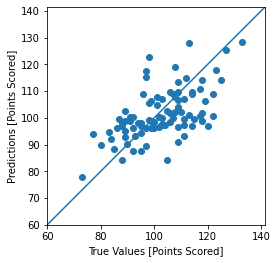

In [65]:
test_predictions = model.predict(normed_test_data).flatten()

plt.scatter(test_labels, test_predictions)
plt.xlabel("True Values [Points Scored]")
plt.ylabel("Predictions [Points Scored]")
plt.axis('equal')
plt.axis('square')
plt.xlim([60, plt.ylim()[1]])
plt.ylim([0, plt.ylim()[1]])
_ = plt.plot([-100,200], [-100, 200])